In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('./data/anomalies/ec2_cpu_utilization_24ae8d.csv')

In [5]:
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [9]:
anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1

df.head()    
    

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [15]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

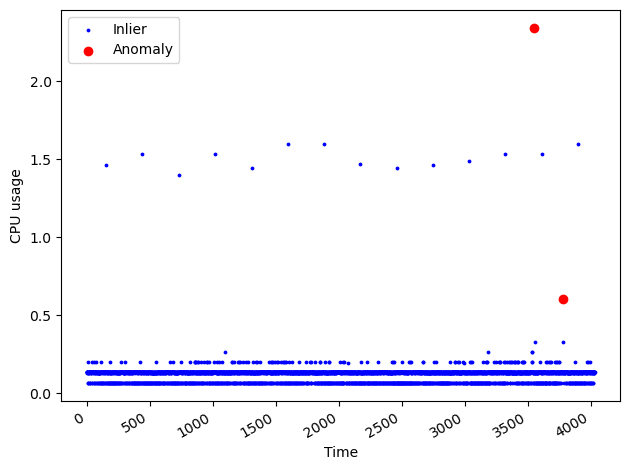

In [17]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

## Mean Absolute Deviation (MAD)

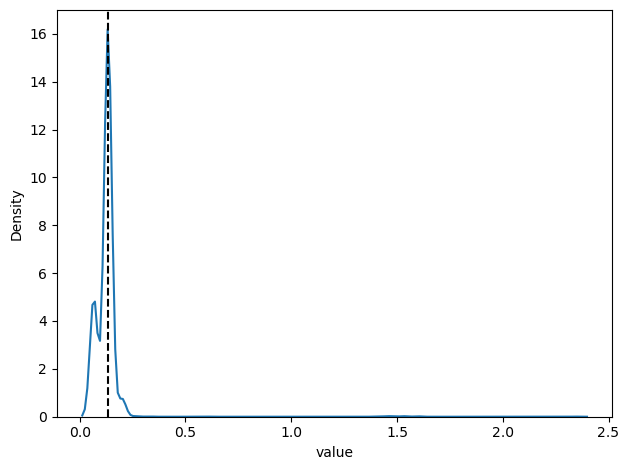

In [31]:
sns.kdeplot(df['value'])
plt.grid(False)
plt.axvline(0.134,0,1, c='black', ls='--')
plt.tight_layout()

In [33]:
from scipy.stats import median_abs_deviation

In [35]:
mad = median_abs_deviation(df['value'])
median = np.median(df['value'])
print(mad, median)

0.0020000000000000018 0.134


In [37]:
def compute_robust_z_score(x):
    return 0.6745*(x-median) / mad

In [39]:
df['z-score'] = df['value'].apply(compute_robust_z_score)

In [41]:
df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [43]:
df['baseline'] = 1
df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <= -3.5, 'baseline'] = -1

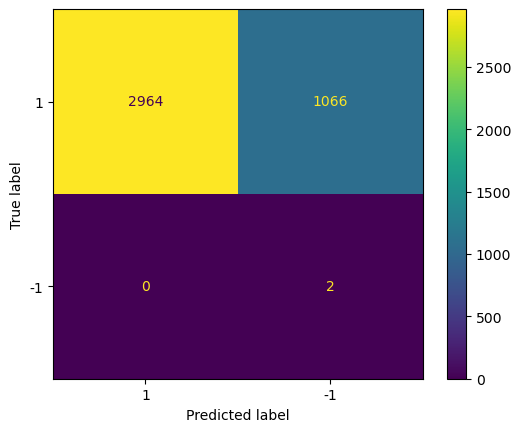

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1,-1])
disp_cm.plot()

plt.grid(False)
plt.tight_layout
plt.show()

## Isolation Forest

In [51]:
from sklearn.ensemble import IsolationForest

In [55]:
train = df[:3550]
test = df[3550:] # one anomaly in each set

In [57]:
contamination = 1/len(train)

In [59]:
iso_forest = IsolationForest(contamination=contamination, random_state=42)
X_train = train['value'].values.reshape(-1,1)

In [65]:
iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [67]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

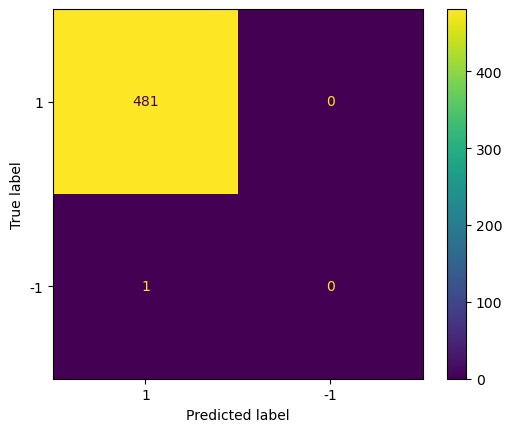

In [69]:
cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1,-1])
disp_cm.plot()

plt.grid(False)
plt.tight_layout
plt.show()

### Local Outlier Factor (LOF)

In [73]:
from sklearn.neighbors import LocalOutlierFactor

In [75]:
lof = LocalOutlierFactor(contamination=contamination, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [77]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

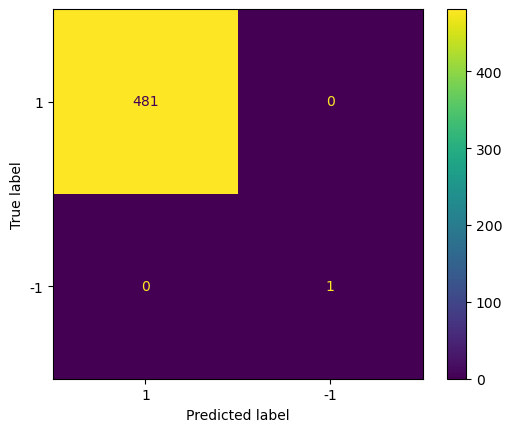

In [79]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1,-1])
disp_cm.plot()

plt.grid(False)
plt.tight_layout
plt.show()

# LSTM
new dataset

In [83]:
df2 = pd.read_csv('./data/anomalies/spx.csv')

In [85]:
df2.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


In [89]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8192 non-null   object 
 1   close   8192 non-null   float64
dtypes: float64(1), object(1)
memory usage: 128.1+ KB


In [97]:
from keras import layers
from keras.models import Sequential
from matplotlib import rc
import tensorflow as tf

In [129]:
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['lines.linewidth'] = 0.5

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

In [101]:
df2['date'] = pd.to_datetime(df2['date'])
df2.index = df2['date']
df2.drop('date',axis=1,inplace=True)

In [103]:
df2.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


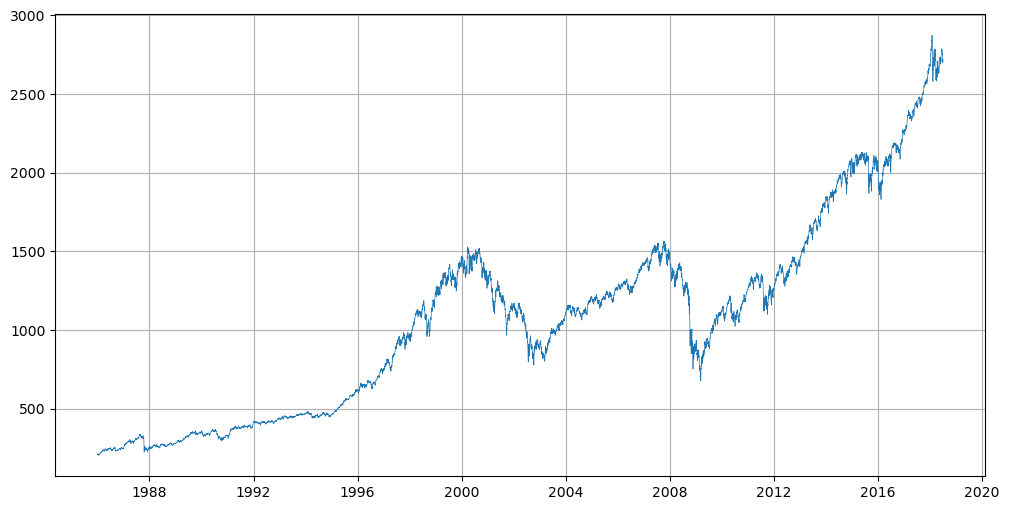

In [131]:
plt.plot(df2, label = 'close price')
plt.grid(True)
plt.show()

In [139]:
train_size = int(len(df2) * .95)
test_size = len(df2) - train_size

In [141]:
train, test = df2.iloc[:train_size], df2.iloc[train_size:]

In [143]:
train.shape, test.shape

((7782, 1), (410, 1))

In [145]:
from sklearn.preprocessing import StandardScaler

In [149]:
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

In [156]:
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

C:\Users\druzh\AppData\Local\Temp\ipykernel_26172\768391793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
C:\Users\druzh\AppData\Local\Temp\ipykernel_26172\768391793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [162]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [172]:
TIME_STEPS = 30
X_train, y_train = create_dataset(train[['close']], train['close'], TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test['close'], TIME_STEPS)

In [174]:
X_train.shape, y_train.shape

((7752, 30, 1), (7752,))

In [176]:
X_test.shape, y_test.shape

((380, 30, 1), (380,))

In [183]:
model_LSTM = Sequential([
    
    layers.InputLayer((X_train.shape[1],X_train.shape[2])),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.RepeatVector(n=X_train.shape[1]),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.TimeDistributed(
        layers.Dense(units=X_train.shape[2])
    )
    
])

model_LSTM.summary()
model_LSTM.compile(loss = 'mae', optimizer = 'adam')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 30, 64)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 1)             65        
 stributed)                                           

In [189]:
history = model_LSTM.fit(
    X_train, y_train, batch_size=32,
    epochs=10,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 11s 52ms/step - loss: 0.1098 - val_loss: 0.1708
Epoch 2/10
218/218 [==============================] - 11s 52ms/step - loss: 0.0971 - val_loss: 0.1387
Epoch 3/10
218/218 [==============================] - 11s 51ms/step - loss: 0.0993 - val_loss: 0.1522
Epoch 4/10
218/218 [==============================] - 11s 52ms/step - loss: 0.1016 - val_loss: 0.2505
Epoch 5/10
218/218 [==============================] - 11s 52ms/step - loss: 0.1208 - val_loss: 0.3070
Epoch 6/10
218/218 [==============================] - 11s 50ms/step - loss: 0.1090 - val_loss: 0.1699
Epoch 7/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1149 - val_loss: 0.1574
Epoch 8/10
218/218 [==============================] - 11s 52ms/step - loss: 0.1103 - val_loss: 0.1485
Epoch 9/10
218/218 [==============================] - 11s 51ms/step - loss: 0.1226 - val_loss: 0.1609
Epoch 10/10
218/218 [==============================] - 11s 51ms/step - loss: 0.128

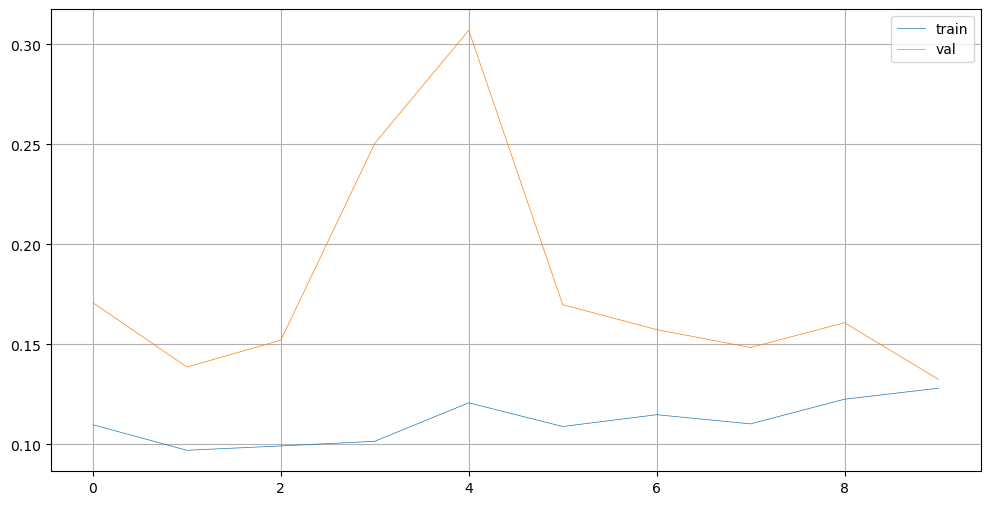

In [200]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.legend();

In [278]:
X_train_pred = model_LSTM.predict(X_train)

243/243 [==============================] - 3s 12ms/step


In [280]:
train_mae_loss = np.mean(np.abs(X_train_pred - X_train),axis=1)

In [282]:
train_mae_loss.shape

(7752, 1)

C:\Users\druzh\AppData\Local\Temp\ipykernel_26172\4276719448.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True)


<Axes: ylabel='Density'>

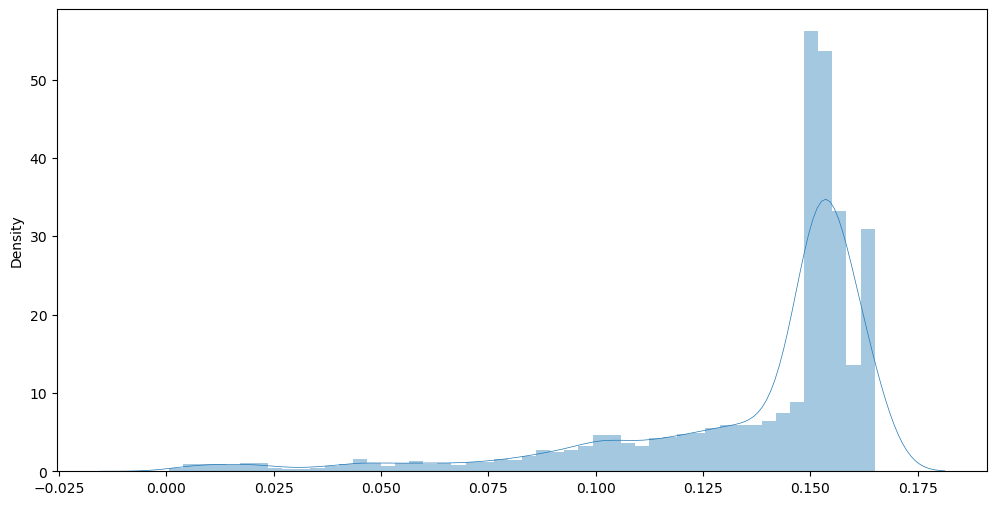

In [284]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [286]:
X_test_pred = model_LSTM.predict(X_test)

12/12 [==============================] - 0s 9ms/step


In [288]:
X_test.shape

(380, 30, 1)

In [290]:
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [292]:
test_mae_loss.shape

(380, 1)

C:\Users\druzh\AppData\Local\Temp\ipykernel_26172\460228650.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_mae_loss, bins=30, kde=True);


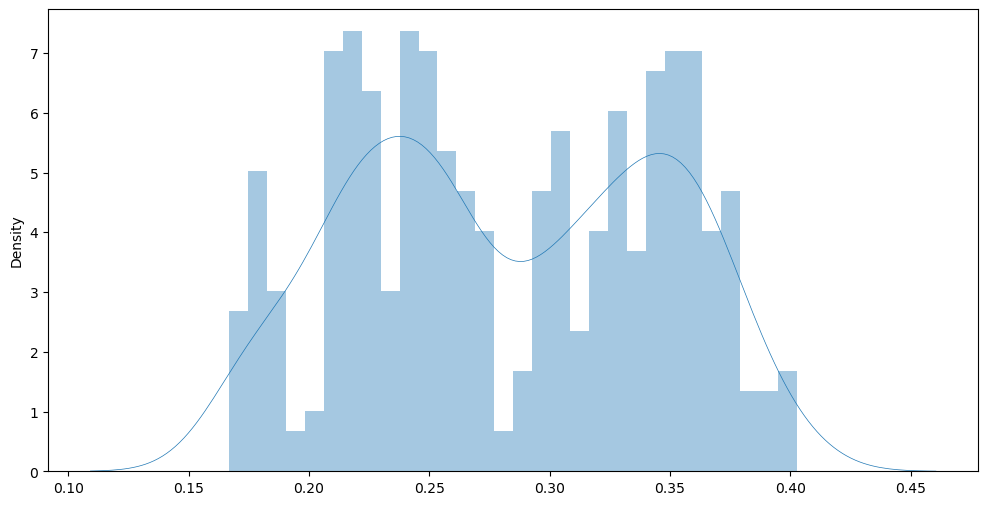

In [294]:
sns.distplot(test_mae_loss, bins=30, kde=True);

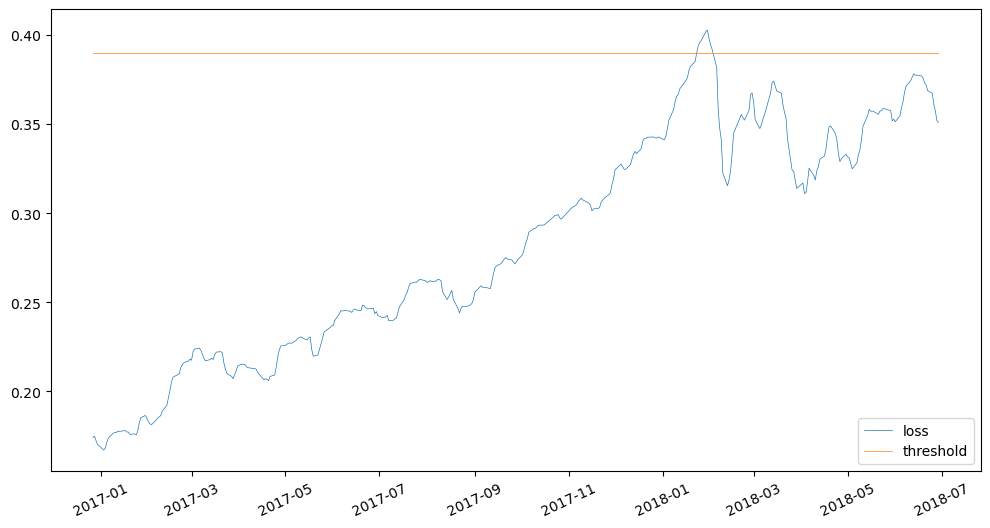

In [377]:
THRESHOLD = 0.39

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [379]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-01-24,0.393881,0.39,True,3.460924
2018-01-25,0.395893,0.39,True,3.464136
2018-01-26,0.396931,0.39,True,3.527284
2018-01-29,0.401954,0.39,True,3.490958
2018-01-30,0.402770,0.39,True,3.432543


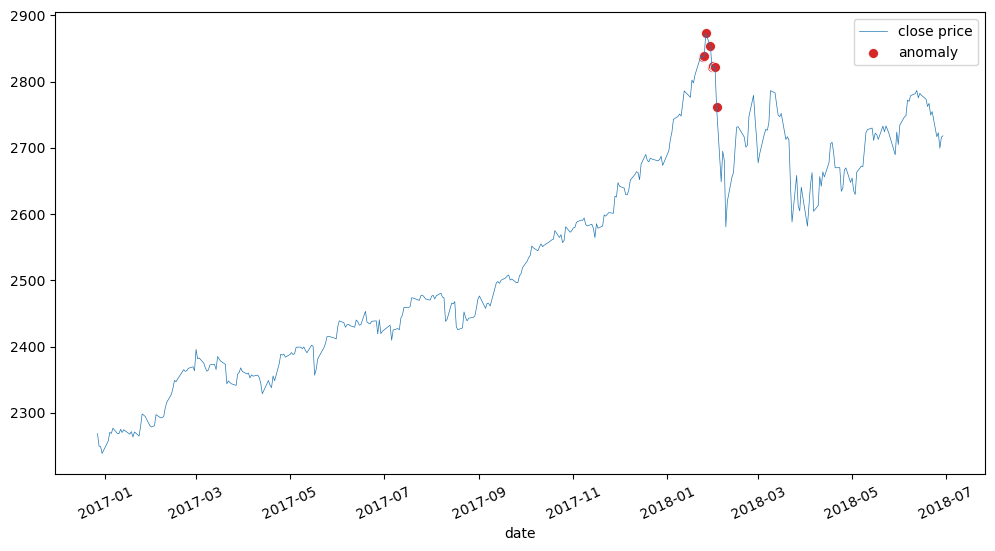

In [382]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(pd.DataFrame(test[TIME_STEPS:].close)), 
  label='close price'
);

sns.scatterplot(
    data = anomalies,
  x = anomalies.index,
  y = scaler.inverse_transform(pd.DataFrame(anomalies.close)).reshape(-1),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();